## 1D Case - Figures 8b and 8d
 
 Investigation of the influence of 
- mesh resolution
 - the number of quadrature points when computing the loss with the Gaussian quadrature rule

The study has been done on fixed and r-adapted meshes.

In [1]:
#%% Libraries import
import sys  
# sys.path.append("../neurom/")


from neurom.HiDeNN_PDE import MeshNN, NeuROM, MeshNN_2D, MeshNN_1D
# Import pre-processing functions
import neurom.src.Pre_processing as pre
# Import torch librairies
import torch
import torch.nn as nn
# Import mechanical functions

from neurom.src.Training import Training_1D_FEM_LBFGS
#Import post processing libraries
import neurom.Post.Plots as Pplot
import time
import os
import torch._dynamo as dynamo
mps_device = torch.device("mps")
from importlib import reload  # Python 3.4+
import tomllib
import numpy as numpy
import argparse


* Executing job in Configuration/config_2D.toml
* WARNING: could not load tikzplotlib


In [2]:
# Load default configuration file (defines dimension, domain, boundary conditions, number of training iterations etc.)
Default_config_file = 'Configurations/config_1D.toml'


with open(Default_config_file, mode="rb") as f:
    config = tomllib.load(f)

In [3]:
# Experiment setting: Gauss quadrature
# Tested variants: 6 mesh resolutions, 3-,4- and 5-point quadrature rule, fixed and r-adaptive mesh

mesh_resolution = [10,21,41,80,160,324]
quadrature_points = [3,4,5]

setting = ["fixed", "r-adaptive"]

config["solver"]["IntegralMethod"] = "Gaussian_quad"

loss_u = numpy.zeros((len(setting),len(mesh_resolution), len(quadrature_points)))
loss_grad = numpy.zeros((len(setting),len(mesh_resolution), len(quadrature_points)))

for q in range(len(quadrature_points)):
    config["interpolation"]["n_integr_points"] = quadrature_points[q]
    for set in range(len(setting)):
        if setting[set] == "fixed":
            config["solver"]["FrozenMesh"] = True
        elif setting[set] == "r-adaptive":
            config["solver"]["FrozenMesh"] = False

        for res in range(len(mesh_resolution)):

            config["interpolation"]["np"] = mesh_resolution[res]
            

            # Load parameters
            if config["interpolation"]["dimension"] == 1:
                Mat = pre.Material(             flag_lame = True,                               # If True should input lmbda and mu instead of E and nu
                                                coef1     = config["material"]["E"],            # Young Modulus
                                                coef2     = config["geometry"]["A"]             # Section area of the 1D bar
                                    )
            elif config["interpolation"]["dimension"] == 2:
                try:
                    Mat = pre.Material(         flag_lame = False,                              # If True should input lmbda and mu instead of E and nu
                                                coef1     = config["material"]["E"],            # Young Modulus
                                                coef2     = config["material"]["nu"]            # Poisson's ratio
                                    )
                except:
                    Mat = pre.Material(         flag_lame = True,                               # If True should input lmbda and mu instead of E and nu
                                                coef1     = config["material"]["lmbda"],        # First Lame's coef
                                                coef2     = config["material"]["mu"]            # Second Lame's coef
                                    )

            MaxElemSize = pre.ElementSize(
                                            dimension     = config["interpolation"]["dimension"],
                                            L             = config["geometry"]["L"],
                                            order         = config["interpolation"]["order"],
                                            np            = config["interpolation"]["np"],
                                        )

            Excluded = []

            Mesh_object = pre.Mesh( 
                                            config["geometry"]["Name"],                 # Create the mesh object
                                            MaxElemSize, 
                                            config["interpolation"]["order"], 
                                            config["interpolation"]["dimension"]
                                    )

            Mesh_object.AddBorders(config["Borders"]["Borders"])
            Mesh_object.AddBCs(                                                         # Include Boundary physical domains infos (BCs+volume)
                                            config["geometry"]["Volume_element"],
                                            Excluded,
                                            config["DirichletDictionryList"]
                                )                   

            Mesh_object.MeshGeo()                                                       # Mesh the .geo file if .msh does not exist
            Mesh_object.ReadMesh() 

            print(config["solver"]["IntegralMethod"])
            print()
            # Vtk file not necessary if not using reference element implementation
            if config["solver"]["IntegralMethod"] == "Gaussian_quad":
                Mesh_object.ExportMeshVtk1D()

            # Build the assembly weight matrix if needed
            if config["interpolation"]["dimension"] ==1 and config["solver"]["IntegralMethod"] == "Trapezoidal":
                Mesh_object.AssemblyMatrix()                                            

            if int(Mesh_object.dim) != int(Mesh_object.dimension):
                raise ValueError("The dimension of the provided geometry does not match the job dimension")

            if config["solver"]["TrainingStrategy"]=="Integral":
                match config["solver"]["IntegralMethod"]:                          
                    case "Gaussian_quad":
                        Model_FEM = MeshNN_1D(Mesh_object, config["interpolation"]["n_integr_points"])  
                    case "Trapezoidal":
                        Model_FEM = MeshNN(Mesh_object)

            if config["solver"]["TrainingStrategy"]=="Mixed":
                if config["solver"]["IntegralMethod"] == "Gaussian_quad":
                    Model_FEM = MeshNN_1D(Mesh_object, config["interpolation"]["n_integr_points"])
                    Model_test = MeshNN_1D(Mesh_object, config["interpolation"]["n_integr_points"])  
                    Model_test.Freeze_Mesh()

            # Default setting
            Model_FEM.Freeze_Mesh()
            Model_FEM.UnFreeze_FEM()

            if not config["solver"]["FrozenMesh"]:
                Model_FEM.UnFreeze_Mesh()    

            if config["solver"]["TrainingStrategy"]=="Mixed":
                Model_FEM = Training_1D_FEM_LBFGS(Model_FEM, config, Mat, Model_test)
            else:
                Model_FEM = Training_1D_FEM_LBFGS(Model_FEM, config, Mat)

            l2_loss, l2_loss_grad = Pplot.Normalized_error_1D(Model_FEM,config,Mat)

            
            loss_u[set, res, q] = l2_loss
            loss_grad[set, res, q] = l2_loss_grad


 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  2024.09.16

************ MESH READING COMPLETE ************

 * Dimension of the problem: 1D
 * Elements type:            2-node bar
 * Number of Dofs:           10
Gaussian_quad


mesh.NNodes =  10
border_nodes :  [[1.0], [2.0]]
self.order =  1
mesh.ListOfDirichletsBCsValues =  [0, 0.005]
IDs =  tensor([[1]], dtype=torch.int32)
IDs =  tensor([0], dtype=torch.int32)
IDs =  tensor([[2]], dtype=torch.int32)
IDs =  tensor([1], dtype=torch.int32)
frozen :  tensor([0], dtype=torch.int32)
frozen :  tensor([1], dtype=torch.int32)
epoch =  1
     loss =  -0.012880413395373335
     loss_decrease =  1.0128804133953733
epoch =  2
     loss =  -0.012880413395373335
     loss_decrease =  0.0
epoch =  3
     loss =  -0.012880413395373335
     loss_decrease =  0.0
epoch =  4
     l

Fixed :  [0.74538078 0.39509747 0.21741465 0.11137825 0.05548029 0.02732404]
Fixed :  [0.744659   0.39509584 0.21741463 0.11137785 0.05548063 0.02732191]
Fixed :  [0.74467163 0.39509585 0.21741463 0.11137784 0.05548108 0.02732794]

Adapt :  [       nan 0.06747639 0.01315608 0.00487374 0.0013304  0.00062885]
Adapt :  [       nan 0.05637289 0.01308851 0.0048737  0.00122884 0.00038636]
Adapt :  [       nan 0.05694514 0.01308796 0.0048737  0.00127661 0.00169349]



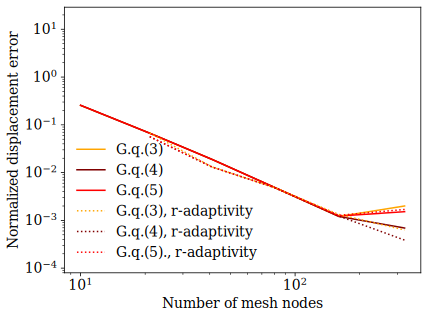

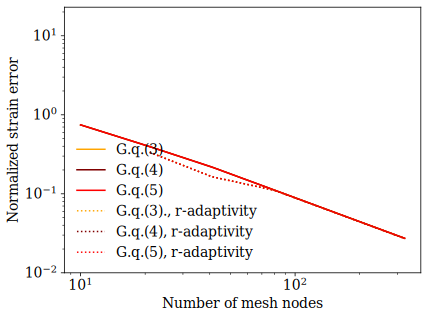

In [4]:
import matplotlib.pyplot as plt
import matplotlib
plt.rcParams['text.usetex'] = False

# Plot normalized displacement error

print("Fixed : ", loss_grad[0,:,0])
print("Fixed : ", loss_grad[0,:,1])
print("Fixed : ", loss_grad[0,:,2])
print()
print("Adapt : ", loss_u[1,:,0])
print("Adapt : ", loss_u[1,:,1])
print("Adapt : ", loss_u[1,:,2])

print()

fig = matplotlib.pyplot.gcf()
ax = plt.gca()

plt.plot(mesh_resolution, loss_u[0,:,0],'-', color = "orange", label = 'G.q.(3)')
plt.plot(mesh_resolution, loss_u[0,:,1],'-', color = "maroon", label = 'G.q.(4)')
plt.plot(mesh_resolution, loss_u[0,:,2],'-', color = "red", label = 'G.q.(5)')

plt.plot(mesh_resolution, loss_u[1,:,0],':', color = "orange", label = 'G.q.(3),  r-adaptivity')
plt.plot(mesh_resolution, loss_u[1,:,1],':', color = "maroon", label = 'G.q.(4),  r-adaptivity')
plt.plot(mesh_resolution, loss_u[1,:,2],':', color = "red", label = 'G.q.(5).,  r-adaptivity')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([0.00008, 29])

plt.xlabel("Number of mesh nodes")
plt.ylabel("Normalized displacement error")
plt.legend(loc="lower left", frameon=False )
plt.show()

# Plot normalized strain error

fig = matplotlib.pyplot.gcf()
ax = plt.gca()

plt.plot(mesh_resolution, loss_grad[0,:,0],'-', color = "orange", label = 'G.q.(3)')
plt.plot(mesh_resolution, loss_grad[0,:,1],'-', color = "maroon", label = 'G.q.(4)')
plt.plot(mesh_resolution, loss_grad[0,:,2],'-', color = "red", label = 'G.q.(5)')

plt.plot(mesh_resolution, loss_grad[1,:,0],':', color = "orange", label = 'G.q.(3).,  r-adaptivity')
plt.plot(mesh_resolution, loss_grad[1,:,1],':', color = "maroon", label = 'G.q.(4),  r-adaptivity')
plt.plot(mesh_resolution, loss_grad[1,:,2],':', color = "red", label = 'G.q.(5),  r-adaptivity')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([0.01, 23])

plt.xlabel("Number of mesh nodes")
plt.ylabel("Normalized strain error")
plt.legend(loc="lower left", frameon=False )
plt.show()


